---
## 🎯 Practice Exercises

### Exercise 1: Adaptive Reflection with Quality Metrics

**Task:** Improve Reflection with numerical quality scoring.

**Requirements:**
1. Critic scores draft on multiple criteria (1-5 each):
   - Clarity
   - Completeness
   - Accuracy
2. Use Pydantic model for structured scoring
3. Only refine if any score < 4
4. Track score improvements across iterations
5. Stop when all scores ≥ 4 or max iterations

**Example:**
```
Iteration 1: Clarity=3, Completeness=4, Accuracy=5 → Refine
Iteration 2: Clarity=5, Completeness=4, Accuracy=5 → Approved!
```

**Deliverables:**
- Reflection agent with quality metrics
- Test with task requiring refinement
- Visualize score improvements

In [2]:
# Import 
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal, TypedDict, Annotated, List
from pydantic import BaseModel, Field
import operator
import os
print("✅ All imports successful")

✅ All imports successful


In [3]:
# Load API key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found!")

print("✅ API key loaded")

✅ API key loaded


In [4]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=openai_api_key
)

print(f"✅ LLM initialized: {llm.model_name}")

✅ LLM initialized: gpt-4o-mini


In [5]:
from typing import List, Dict, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

# 1. Pydantic model for structured scoring
class QualityScores(BaseModel):
    clarity: int = Field(description="Score 1-5 for clarity", ge=1, le=5)
    completeness: int = Field(description="Score 1-5 for completeness", ge=1, le=5)
    accuracy: int = Field(description="Score 1-5 for accuracy", ge=1, le=5)
    critique: str = Field(description="Specific, actionable feedback for refinement")

# Reflection state
class ReflectionState(TypedDict):
    task: str   # Original task
    draft: str  # current draft
    critique: str   #Criticizing the draft
    scores_history: List[Dict]  # Track numerical improvement
    iterations: int #Number of refinements
    final_output: str   # Result

MAX_REFLECTIONS = 3

print("✅ Reflection state with Critique and Pydantic constraints defined")

✅ Reflection state with Critique and Pydantic constraints defined


In [10]:
# Node 1: Generator
def generator(state: ReflectionState) -> dict:
    """Generate or refine based on numerical scores and critique."""
    if state["iterations"] == 0:
        prompt = f"Task: {state['task']}\n\nProvide a high-quality, accurate response."
        print("\n✍️ Generating initial draft...")
    else:
        # Use the explicit critique and scores to guide the next version
        prompt = f"""Improve this draft based on the critique.
        
        Task: {state['task']}
        Current draft: {state['draft']}
        
        Specific Critique: {state['critique']}
        
        Focus on reaching a score of 5 in all categories."""
        print(f"\n✍️ Refining (iteration {state['iterations']})...")
    
    response = llm.invoke(prompt)
    return {"draft": response.content}

# Node 2: Critic (Structured)
def critic(state: ReflectionState) -> dict:
    """Evaluate draft and return structured feedback."""
    print("🔍 Critiquing draft with numerical metrics...")
    
    structured_llm = llm.with_structured_output(QualityScores)
    
    prompt = f"""Evaluate this response on Clarity, Completeness, and Accuracy (1-5).
    Provide a specific critique for the generator.
    
    Task: {state['task']}
    Response: {state['draft']}"""
    
    # This returns a QualityScores object
    evaluation = structured_llm.invoke(prompt)
    
    print(f"📊 Scores: Clarity={evaluation.clarity}, Comp={evaluation.completeness}, Acc={evaluation.accuracy}")
    
    return {
        "critique": evaluation.critique,
        "scores_history": [evaluation.model_dump()],
        "iterations": state["iterations"] + 1
    }

# Node 3: Finalizer
def reflection_finalizer(state: ReflectionState) -> dict:
    print("\n✅ Target quality reached or Max iterations hit.")
    return {"final_output": state["draft"]}

print("✅ Generator and Critic nodes defined")

✅ Generator and Critic nodes defined


In [11]:
# Routing function based on numerical criteria
def should_reflect_again(state: ReflectionState) -> Literal["generator", "finalizer"]:
    """Refine only if any numerical score is < 4."""
    if not state["scores_history"]:
        return "generator"
        
    last_scores = state["scores_history"][-1]
    
    # Check numerical thresholds (Clarity, Completeness, Accuracy)
    # We ignore the 'critique' string during the numerical math check
    scores_only = [v for k, v in last_scores.items() if isinstance(v, int)]
    met_threshold = all(score >= 4 for score in scores_only)
    
    if met_threshold:
        print("⭐ Quality threshold met (All scores >= 4)!")
        return "finalizer"
    
    if state["iterations"] >= MAX_REFLECTIONS:
        print(f"⚠️ Max iterations ({MAX_REFLECTIONS}) reached.")
        return "finalizer"
    
    return "generator"

# Build Reflection graph
reflection_builder = StateGraph(ReflectionState)

reflection_builder.add_node("generator", generator)
reflection_builder.add_node("critic", critic)
reflection_builder.add_node("finalizer", reflection_finalizer)

reflection_builder.add_edge(START, "generator")
reflection_builder.add_edge("generator", "critic")
reflection_builder.add_conditional_edges(
    "critic",
    should_reflect_again,
    {"generator": "generator", "finalizer": "finalizer"}
)
reflection_builder.add_edge("finalizer", END)

reflection_agent = reflection_builder.compile()

print("✅ Adaptive Reflection agent with Quality Metrics created")

✅ Adaptive Reflection agent with Quality Metrics created


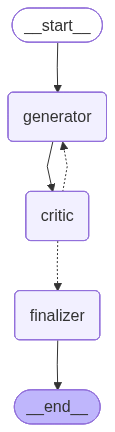

In [8]:
# Visualize
try:
    display(Image(reflection_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START → generator → critic (loops back to generator) → finalizer → END")

In [12]:
result = reflection_agent.invoke({
    "task": "Explain RAG agent in 3-4 lines",
    "draft": "",
    "critique": "",
    "iterations": 0
})

print(f"\n{'='*70}")
print("📊 FINAL OUTPUT (after reflection):")
print(f"{'='*70}")
print(result["final_output"])
print(f"\nTotal iterations: {result['iterations']}")
print(f"{'='*70}\n")


✍️ Generating initial draft...
🔍 Critiquing draft with numerical metrics...
📊 Scores: Clarity=5, Comp=5, Acc=5
⭐ Quality threshold met (All scores >= 4)!

✅ Target quality reached or Max iterations hit.

📊 FINAL OUTPUT (after reflection):
A RAG (Retrieval-Augmented Generation) agent combines retrieval-based and generative approaches to enhance natural language processing tasks. It retrieves relevant information from a knowledge base or external documents and uses that data to inform and improve the quality of its generated responses. This hybrid model allows for more accurate and contextually relevant outputs, making it particularly effective for applications like question answering and conversational agents.

Total iterations: 1

